In [24]:
import os
import contextlib
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

SAVE_DIR = "fig"


In [2]:
@contextlib.contextmanager
def set_mpl_params():
    # Enable LaTeX rendering
    mpl.rcParams["text.usetex"] = True

    # Optionally set the font to be similar to LaTeX's default font
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Computer Modern Roman"

    mpl.rcParams["font.size"] = 12

    yield


# Utils

In [3]:
def get_env_from_path(path):
    full_env_name = path.split("/")[2]
    for env in ["umaze", "medium", "large"]:
        if env in full_env_name:
            return env
    raise ValueError(f"Unknown environment for path {path}")


def get_value_head_from_path(path):
    for head in ["iqe", "l2", "mlp", "inner_prod"]:
        if head in path:
            return head
    raise ValueError(f"Unknown value head for path {path}")


def get_value_head_dim_from_path(path):
    params = path.split("/")[3]
    for dim in [2048, 4096]:
        if str(dim) in params:
            return dim
    raise ValueError(f"Unknown value head dim for path {path}")


def load_value_func_data_from_paths(filepaths):
    all_data = []

    for filepath in filepaths:
        with open(filepath, "rb") as f:
            data = pickle.load(f)

        for d in data:
            k = d["k"]
            rmse = np.sqrt(((np.concatenate(d["values"]) - k) ** 2).mean())
            entry = {key: d[key] for key in ["epoch", "iter", "k"]}
            entry["rmse"] = rmse
            entry["env"] = get_env_from_path(filepath)
            entry["value_head"] = get_value_head_from_path(filepath)
            entry["dim"] = get_value_head_dim_from_path(filepath)
            entry["filepath"] = filepath
            all_data.append(entry)

    return pd.DataFrame(all_data)


# Value function error plot

In [4]:
filepaths = glob.glob("offline/results_value_func2/*/*/*.pkl", recursive=True)
df = load_value_func_data_from_paths(filepaths)


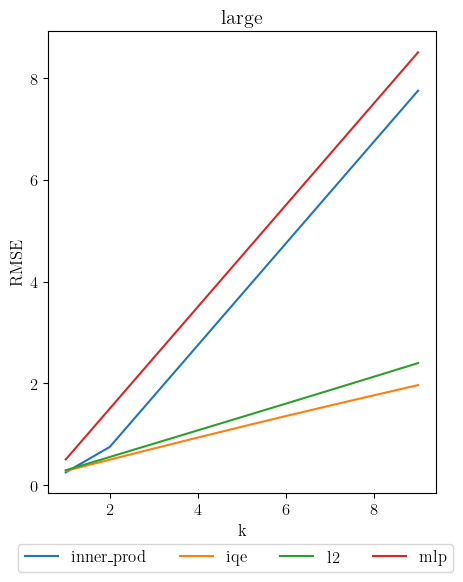

In [5]:
# Set LaTeX style font
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 12

# Unique environments in reverse alphabetical order
# envs = sorted(df["env"].unique(), reverse=True)
envs = ["large"]

# Create a figure with a subplot for each environment
fig, axes = plt.subplots(1, len(envs), figsize=(5 * len(envs), 6), sharey=True)

# Track handles for legend
handles_dict = {}

subset_df = df[df["dim"] == 2048]

for i, env in enumerate(envs):
    ax = axes[i] if len(envs) > 1 else axes
    env_df = subset_df[subset_df["env"] == env]

    # Group by value_head and find the largest epoch for each
    for value_head, group in env_df.groupby("value_head"):
        max_epoch = group["epoch"].max()
        subset = group[group["epoch"] == max_epoch]
        subset = subset.sort_values("k")

        (line,) = ax.plot(subset["k"], subset["rmse"], label=value_head)
        handles_dict[value_head] = line

        # print(f"env={env}, value_head={value_head}, rmse={subset['rmse']}")

    ax.set_title(env)
    ax.set_xlabel("k")
    if i == 0:  # Add y-label to only the first subplot
        ax.set_ylabel("RMSE")

# Combine legend handles
handles, labels = zip(*[(h, vh) for vh, h in handles_dict.items()])

# Add one combined legend below the subplots
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(handles),
    bbox_to_anchor=(0.5, -0.035),
)

# Adjust layout
plt.savefig(os.path.join(SAVE_DIR, "value_func_rmse.pdf"), bbox_inches="tight")
plt.show()


# Policy performance bar plot

In [16]:
def should_keep_experiment(exp):
    metric = exp.split("/")[-1]
    return not metric.endswith("MAX") and not metric.endswith("MIN")


def rename_experiment(exp):
    return "/".join(exp.split("/")[:-1])


def get_env(exp):
    return exp.split("/")[0]


def get_value_head(exp):
    value_head = exp.split("/")[1]
    if value_head.startswith("mlp"):
        return "mlp"
    elif value_head.startswith("iqe"):
        return "iqe"
    elif value_head.startswith("inner_prod"):
        return "inner_prod"
    elif value_head.startswith("l2"):
        return "l2"
    else:
        raise NotImplementedError()


def get_rewards_df():
    # Load the CSV files
    avg_rewards_df = pd.read_csv(
        "offline/wand_export/avg_reward_all_mazes_all_ckpts_wandb_export_2023-12-06T10_34_46.421-08_00.csv"
    )
    std_dev_df = pd.read_csv(
        "offline/wand_export/std_reward_all_mazes_all_ckpts_wandb_export_2023-12-06T10_37_36.175-08_00.csv"
    )

    # Reshape the DataFrames from wide to long format
    avg_rewards_long = avg_rewards_df.melt(
        id_vars="Step", var_name="experiment", value_name="avg_reward"
    )
    std_dev_long = std_dev_df.melt(
        id_vars="Step", var_name="experiment", value_name="std_reward"
    )

    avg_rewards_long = avg_rewards_long[
        avg_rewards_long.experiment.apply(should_keep_experiment)
    ]
    std_dev_long = std_dev_long[
        std_dev_long.experiment.apply(should_keep_experiment)
    ]

    avg_rewards_long["experiment"] = avg_rewards_long.experiment.apply(
        rename_experiment
    )
    std_dev_long["experiment"] = std_dev_long.experiment.apply(
        rename_experiment
    )

    # Merge the DataFrames on 'Step' (epoch) and 'experiment'
    merged_df = pd.merge(
        avg_rewards_long, std_dev_long, on=["Step", "experiment"]
    )

    # Rename 'Step' column to 'epoch'
    merged_df.rename(columns={"Step": "epoch"}, inplace=True)

    merged_df["env"] = merged_df.experiment.apply(get_env)
    merged_df["value_head"] = merged_df.experiment.apply(get_value_head)

    return merged_df


In [17]:
merged_df = get_rewards_df()


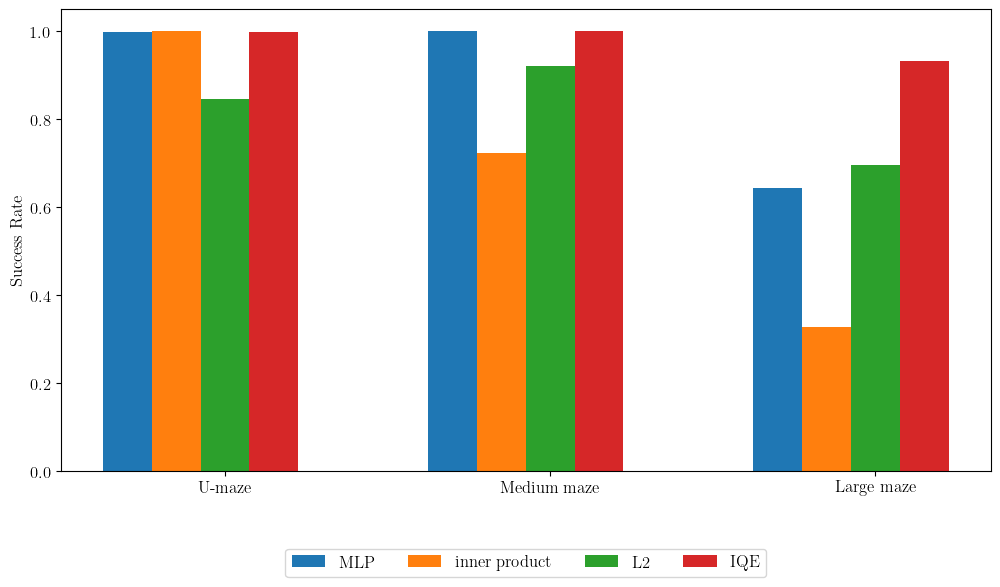

In [21]:
# Enable LaTeX rendering
mpl.rcParams["text.usetex"] = True

# Optionally set the font to be similar to LaTeX's default font
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"

mpl.rcParams["font.size"] = 12

# Find the maximum avg_reward for each combination of env and value_head
max_rewards_df = (
    merged_df.groupby(["env", "value_head"])["avg_reward"].max().reset_index()
)

# Set the figure size
plt.figure(figsize=(12, 6))

# Unique environments
envs = sorted(max_rewards_df["env"].unique(), reverse=True)

# Initialize the base position for the first set of bars
indices = np.arange(len(envs))
bar_width = 0.15  # You can adjust the width based on your data
offset = 0

# Plot bars for each value_head within each env
VALUE_HEAD_TO_LABEL = {
    "mlp": "MLP",
    "inner_prod": "inner product",
    "l2": "L2",
    "iqe": "IQE",
}
# for value_head in max_rewards_df['value_head'].unique():
for value_head, label in VALUE_HEAD_TO_LABEL.items():
    # Filter data for each value_head
    subset = max_rewards_df[max_rewards_df["value_head"] == value_head]

    # Create a list of rewards for each env, filling missing values with 0
    rewards = [
        subset[subset["env"] == env]["avg_reward"].max()
        if env in subset["env"].values
        else 0
        for env in envs
    ]

    # Plot the bars
    plt.bar(indices + offset, rewards, width=bar_width, label=label)

    # Offset to position the next set of bars
    offset += bar_width

# Add labels, title, and legend
# plt.xlabel("Environment")
plt.ylabel("Success Rate")

ENV_NAME_TO_LABEL = {
    "d4rl_maze2d-umaze-v1": "U-maze",
    "d4rl_maze2d-medium-v1": "Medium maze",
    "d4rl_maze2d-large-v1": "Large maze",
}
env_names = [ENV_NAME_TO_LABEL[env] for env in envs]
plt.xticks(indices + offset / 2, env_names)

#  Adjust legend to appear in one horizontal box below the plot
plt.legend(
    bbox_to_anchor=(0.5, -0.15),
    loc="upper center",
    ncol=len(VALUE_HEAD_TO_LABEL),
)

# Adjust layout to accommodate the bottom legend
# plt.tight_layout(rect=[0, 0.1, 1, 1])

# Save the plot
plt.savefig(
    os.path.join(SAVE_DIR, "mazes_success_rate.pdf"), bbox_inches="tight"
)

# Show the plot
plt.show()


# Sample complexity plot

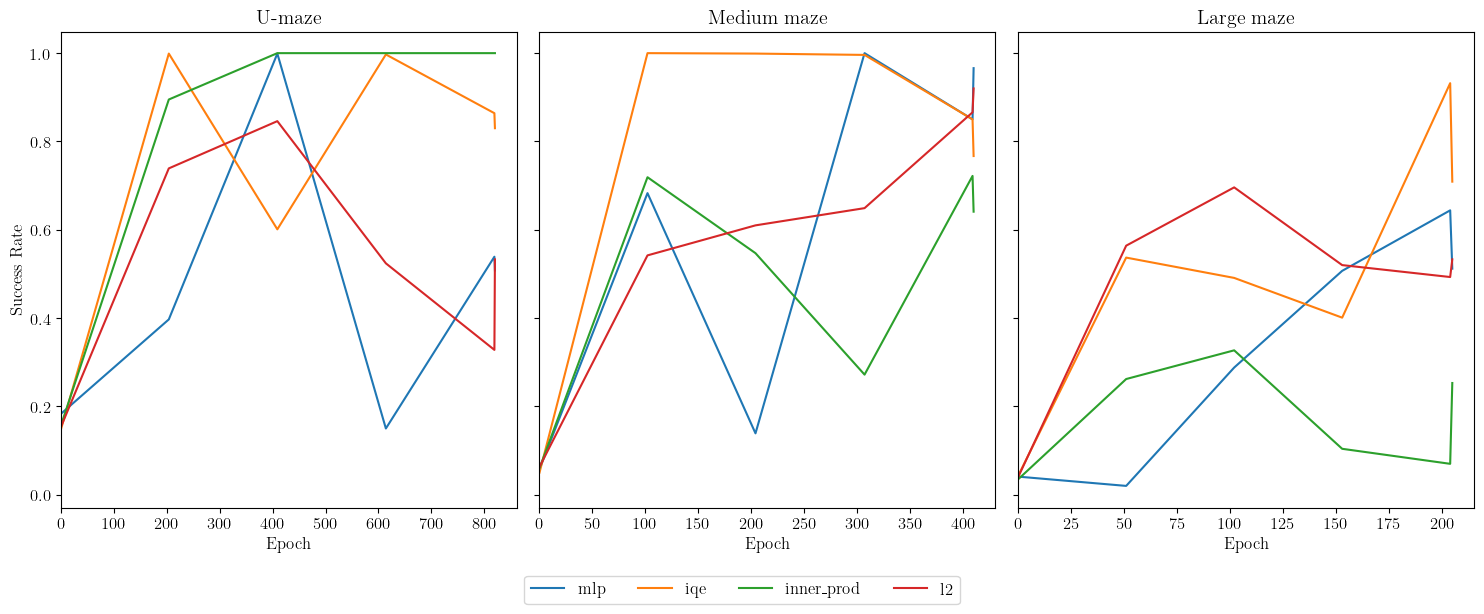

In [23]:
# Set LaTeX style font
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.size"] = 12

# Unique environments and value heads
envs = sorted(merged_df["env"].unique(), reverse=True)
value_heads = merged_df["value_head"].unique()

# Create a figure with a subplot for each environment
fig, axes = plt.subplots(1, len(envs), figsize=(5 * len(envs), 6), sharey=True)

# Track handles for legend
handles_dict = {}

ENV_NAME_TO_LABEL = {
    "d4rl_maze2d-umaze-v1": "U-maze",
    "d4rl_maze2d-medium-v1": "Medium maze",
    "d4rl_maze2d-large-v1": "Large maze",
}

for i, env in enumerate(envs):
    ax = axes[i] if len(envs) > 1 else axes
    env_df = merged_df[merged_df["env"] == env]

    # Calculate max epoch for the current environment after dropping NaNs
    max_epoch = env_df.dropna(subset=["avg_reward"])["epoch"].max()
    buffer = max_epoch * 0.05  # 5% buffer
    ax.set_xlim([0, max_epoch + buffer])

    for value_head in value_heads:
        subset = env_df[env_df["value_head"] == value_head]

        # Skip NaN in avg_reward
        subset = subset.dropna(subset=["avg_reward"])

        # Plot only if there is data
        if not subset.empty:
            (line,) = ax.plot(
                subset["epoch"], subset["avg_reward"], label=value_head
            )
            handles_dict[value_head] = line

    ax.set_title(ENV_NAME_TO_LABEL[env])
    ax.set_xlabel("Epoch")
    if i == 0:  # Add y-label to only the first subplot
        ax.set_ylabel("Success Rate")

# Combine legend handles
handles, labels = zip(*[(h, vh) for vh, h in handles_dict.items()])

# Add one combined legend
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(handles),
    bbox_to_anchor=(0.5, -0.035),
)

# Adjust layout
plt.tight_layout(rect=[0, 0.035, 1, 1])
plt.savefig(
    os.path.join(SAVE_DIR, "mazes_sample_complexity.pdf"), bbox_inches="tight"
)
plt.show()
